# Kobak and Berens implementation for tasic data

Here, we will compare the sample based approach to Kobak and Berens approach

In [2]:
from time import time
from datetime import datetime
from pathlib import Path
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from scipy import sparse

import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import pickle
import pandas as pd

sns.set_style('ticks')

sys.path.insert(0, r"C:\Users\arsla\my_files\research_project\mg-emb-exps-main-KB\mg-emb-exps-main-KB")
from src.utils.load_dataset import get_mnist, get_fmnist, load_flow18, load_wong, load_celegans, get_tasic2018
from src.utils import rnaseqTools

# the path should point to the FIt-SNE directory
sys.path.append('../FIt-SNE')
from fast_tsne import fast_tsne

### Load data

In [3]:
path = Path("C:/Users/arsla/my_files/research_project/mg-emb-exps-main-KB/mg-emb-exps-main-KB/data")

path_to_data = Path(path)

if path_to_data.joinpath("tasic2018.pickle").exists():
    print("[tasic2018] Pickle found. Loading it.")
    with open(str(path_to_data.joinpath("tasic2018.pickle")), "rb") as f:
        tasic2018 = pickle.load(f)
else:

    filename = path_to_data.joinpath("mouse_VISp_gene_expression_matrices_2018-06-14",
                                        "mouse_VISp_2018-06-14_exon-matrix.csv")
    counts1, genes1, cells1 = rnaseqTools.sparseload(str(filename))

    filename = path_to_data.joinpath("mouse_ALM_gene_expression_matrices_2018-06-14",
                                        "mouse_ALM_2018-06-14_exon-matrix.csv")
    counts2, genes2, cells2 = rnaseqTools.sparseload(filename)

    counts = sparse.vstack((counts1, counts2), format='csc')

    cells = np.concatenate((cells1, cells2))

    if np.all(genes1 == genes2):
        genes = np.copy(genes1)

    filename = path_to_data.joinpath("mouse_VISp_gene_expression_matrices_2018-06-14",
                                        "mouse_VISp_2018-06-14_genes-rows.csv")
    genesDF = pd.read_csv(str(filename))
    ids = genesDF['gene_entrez_id'].tolist()
    symbols = genesDF['gene_symbol'].tolist()
    id2symbol = dict(zip(ids, symbols))
    genes = np.array([id2symbol[g] for g in genes])

    filename = path_to_data.joinpath("tasic-sample_heatmap_plot_data.csv")
    clusterInfo = pd.read_csv(str(filename))
    goodCells = clusterInfo['sample_name'].values
    ids = clusterInfo['cluster_id'].values
    labels = clusterInfo['cluster_label'].values
    colors = clusterInfo['cluster_color'].values

    clusterNames = np.array([labels[ids == i + 1][0] for i in range(np.max(ids))])
    clusterColors = np.array([colors[ids == i + 1][0] for i in range(np.max(ids))])
    clusters = np.copy(ids)

    ind = np.array([np.where(cells == c)[0][0] for c in goodCells])
    counts = counts[ind, :]

    areas = (ind < cells1.size).astype(int)

    clusters = clusters - 1

    markerGenes = ['Snap25', 'Gad1', 'Slc17a7', 'Pvalb', 'Sst', 'Vip', 'Aqp4',
                    'Mog', 'Itgam', 'Pdgfra', 'Flt1', 'Bgn', 'Rorb', 'Foxp2']

    tasic2018 = {'counts': counts, 'genes': genes, 'clusters': clusters, 'areas': areas,
                    'clusterColors': clusterColors, 'clusterNames': clusterNames}

    tasic2018["importantGenesTasic2018"] = rnaseqTools.geneSelection(
        tasic2018['counts'], n=3000, threshold=32)

    with open(str(path_to_data.joinpath("tasic2018.pickle")), "wb") as f:
        pickle.dump(tasic2018, f)

    print(tasic2018['counts'].shape)
    print(np.sum(tasic2018['areas'] == 0))
    print(np.sum(tasic2018['areas'] == 1))
    print(np.unique(tasic2018['clusters']).size)

# librarySizes = np.sum(tasic2018['counts'], axis=1)
# X = np.log2(tasic2018['counts'][:, tasic2018["importantGenesTasic2018"]] / librarySizes * 1e+6 + 1)
# X = np.array(X)
# X = X - X.mean(axis=0)
# U, s, V = np.linalg.svd(X, full_matrices=False)
# U[:, np.sum(V, axis=1) < 0] *= -1
# X = np.dot(U, np.diag(s))
# X = X[:, np.argsort(s)[::-1]][:, :50]

labels = tasic2018["clusters"]

librarySizes = np.sum(tasic2018['counts'], axis=1).A1  # .A1 flattens the sparse matrix sum
counts_selected = tasic2018['counts'][:, tasic2018["importantGenesTasic2018"]].toarray()
norm_counts = (counts_selected.T / librarySizes).T * 1e6
X = np.log2(norm_counts + 1)
X = X - X.mean(axis=0)
X_hd = X.copy()  # <--- This is your high-dimensional data

# reduce dimensions
U, s, V = np.linalg.svd(X, full_matrices=False)
U[:, np.sum(V, axis=1) < 0] *= -1
X = np.dot(U, np.diag(s))
initial_embedding = X[:, np.argsort(s)[::-1]][:, :50]

# --- Preprocessing: same as original ---
# librarySizes = np.sum(tasic2018['counts'], axis=1).A1  # Flatten sparse matrix sum
# counts_selected = tasic2018['counts'][:, tasic2018["importantGenesTasic2018"]].toarray()
# # Normalize: Counts per million (CPM)
# norm_counts = (counts_selected.T / librarySizes).T * 1e6
# # Log-transform
# X = np.log2(norm_counts + 1)
# # Center each gene (mean = 0 across cells)
# X = X - X.mean(axis=0)
# # --- PCA for dimensionality reduction ---
# pca = PCA(n_components=50, random_state=42)
# X_pca = pca.fit_transform(X)
# # This X_pca can now be used as the initial embedding for t-SNE
# initial_embedding = X_pca


[tasic2018] Pickle found. Loading it.


### Plotting and Saving figure logic

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_grid(embedding, quality, tasic2018, title="", panel_letter=None):

    colors = tasic2018["clusterColors"][tasic2018["clusters"]]
    classes = {
        'Lamp5': [-35, -12, 'Lamp5 Lsp1'],
        'Vip':   [15, 30, 'Vip Rspo4 Rxfp1 Chat'],
        'Pvalb': [-4, 32, 'Pvalb Reln Tac1'],
        'Sst':   [-32, 18, 'Sst Myh8 Fibin'],
        'L2/3 IT': [-30, -30, 'L2/3 IT ALM Sla'],
        'L5 IT': [-10, -25, 'L5 IT ALM Tnc'],
        'L6 IT': [6, -4, 'L6 IT VISp Penk Col27a1'],
        'L5 PT': [23, -25, 'L5 PT ALM Hpgd'],
        'L5 NP': [-23, -40, 'L5 NP VISp Trhr Cpne7'],
        'L6 CT': [30, 12, 'L6 CT VISp Nxph2 Wls'],
        'L6b':   [35, -11, 'L6b P2ry12'],
        'Non-neurons': [20, -20, 'Astro Aqp4']
    }

    sns.set(style="white")
    fig = plt.figure(figsize=(4, 4))
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='datalim')
    ax.scatter(
        embedding[:, 0], embedding[:, 1],
        s=2, c=colors, edgecolor='none', rasterized=True
    )

    ax.set_title(title, va='center')
    ax.text(0.75, .02, 'KNN:\nKNC:\nCPD:', transform=ax.transAxes, fontsize=9)
    ax.text(0.87, .02, '{:.2f}\n{:.2f}\n{:.2f}'.format(*quality), transform=ax.transAxes, fontsize=9)
    ax.text(0, 1.05, panel_letter, transform=ax.transAxes, fontsize=8, fontweight='bold')
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, left=True, bottom=True)

    for c in classes:
        x, y, cname = classes[c]
        cluster_idx = np.where(tasic2018['clusterNames'] == cname)[0]
        color = tasic2018['clusterColors'][cluster_idx[0]] if cluster_idx.size > 0 else 'black'
        ax.text(x, y, c, fontsize=6, color=color)

    plt.tight_layout()

    plt.show()
    return fig


In [5]:
def save_fig(figure, dataset_id, fname, overwrite=False):

    # Get current date formatted as dd-mm-yy
    folder_timestamp = datetime.now().strftime("%d-%m-%y")

    if dataset_id is not None:
        figures_dir = Path.cwd() / "figures" / "kobak-berens" /dataset_id / folder_timestamp
        figures_dir.mkdir(parents=True, exist_ok=True)
    else:
        # Default figures directory
        figures_dir = Path.cwd() / "figures" / "kobak-berens" / "default"
        figures_dir.mkdir(parents=True, exist_ok=True)

    full_path = figures_dir / fname

    if full_path.exists() and not overwrite:
        print(f"File already exists. Remove or rename {full_path} before continuing.")
    else:
        figure.savefig(full_path)
        print(f"Figure saved to {full_path}")

### Kobak and Berens implementation

In [6]:
def kb_tsne(
    initial_embedding,
    rnd_state=42
):
    start = time()
    n = initial_embedding.shape[0]
    print(f"Number of points in the dataset: {n}")
        
    print("Dataset is small enough, running fast_tsne directly on the full dataset.")
    # Small dataset: combine perplexities [30, n/100]
    perplist = [30]
    if n / 100 > 30:
        perplist.append(n / 100)
    
    search_k = int(3 * max(perplist) * 50)  # 50 is the default n_trees
    pcaInit = initial_embedding[:,:2] / np.std(initial_embedding[:,0]) * 0.0001
    
    print("Applying fast_tsne for the small dataset with perplexities:", perplist)
    embedding = fast_tsne(
        initial_embedding,
        initialization="pca",
        perplexity=0,
        perplexity_list=perplist,
        search_k=search_k,
        
        early_exag_coeff=12,
        stop_early_exag_iter=250,
        max_iter=1000,
        
        learning_rate="auto",
        momentum=0.5,
        final_momentum=0.8,
        seed=rnd_state
    )
    print("DONE.")
    

    print(f"-> Total time for running kb_tsne took {(time() - start) / 60:.2f} minutes.")
    return embedding


#### Embedding Quality method

In [7]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr

def embedding_quality(X, Z, classes, knn=10, knn_classes=4, subsetsize=1000):
    # Local neighborhood preservation (kNN)
    nbrs1 = NearestNeighbors(n_neighbors=knn).fit(X)
    ind1 = nbrs1.kneighbors(return_distance=False)

    nbrs2 = NearestNeighbors(n_neighbors=knn).fit(Z)
    ind2 = nbrs2.kneighbors(return_distance=False)

    intersections = 0.0
    for i in range(X.shape[0]):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn = intersections / (X.shape[0] * knn)

    # Global neighborhood consistency (KNC)
    cl, cl_inv = np.unique(classes, return_inverse=True)
    C = cl.size

    mu1 = np.zeros((C, X.shape[1]))
    mu2 = np.zeros((C, Z.shape[1]))
    for c in range(C):
        mu1[c, :] = np.mean(X[cl_inv == c, :], axis=0)
        mu2[c, :] = np.mean(Z[cl_inv == c, :], axis=0)

    knn_classes = min(knn_classes, max(1, C - 1))  # Prevent requesting more neighbors than class centers
    nbrs1 = NearestNeighbors(n_neighbors=knn_classes).fit(mu1)
    ind1 = nbrs1.kneighbors(return_distance=False)

    nbrs2 = NearestNeighbors(n_neighbors=knn_classes).fit(mu2)
    ind2 = nbrs2.kneighbors(return_distance=False)

    intersections = 0.0
    for i in range(C):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn_global = intersections / (C * knn_classes)

    # Spearman correlation of pairwise distances (CPD)
    subset = np.random.choice(X.shape[0], size=subsetsize, replace=False)
    d1 = pdist(X[subset, :])
    d2 = pdist(Z[subset, :])
    rho = spearmanr(d1, d2).correlation

    return mnn, mnn_global, rho

### Prepare experiment config

In [8]:
sample_rate = 0.1

### Run kb_tsne

In [10]:
# Run kb_tsne
print("Running kb_tsne...")
kb_output = kb_tsne(
    initial_embedding=initial_embedding,
    rnd_state=42,
)

final_embedding = kb_output
print("finished running kb_tsne.")

Running kb_tsne...
Number of points in the dataset: 23822
Dataset is small enough, running fast_tsne directly on the full dataset.
Applying fast_tsne for the small dataset with perplexities: [30, 238.22]
DONE.
-> Total time for running kb_tsne took 1.32 minutes.
finished running kb_tsne.


### Calculate Embedding Qualities

In [11]:
subset_size = 1000
kb_mnn, kb_knc, kb_cpd = embedding_quality(
    initial_embedding, final_embedding, labels, knn=10, knn_classes=4, subsetsize=subset_size
)
print(f"Quality metrics for kb_tsne: KNN={kb_mnn:.2f}, KNC={kb_knc:.2f}, CPD={kb_cpd:.2f}")

Quality metrics for kb_tsne: KNN=0.41, KNC=0.74, CPD=0.58


### Plot And Save

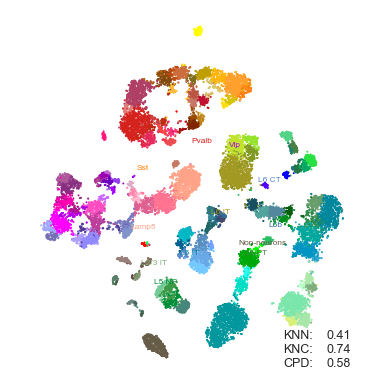

Figure saved to c:\Users\arsla\my_files\research_project\mg-emb-exps-main-KB-2\mg-emb-exps-main-KB\src\figures\kobak-berens\tasic\22-06-25\tasic_~_05-24-52.png


In [25]:
quality = (kb_mnn, kb_knc, kb_cpd)
figure = plot_grid(final_embedding, quality, tasic2018, panel_letter=None)

# save the figure
file_name_timestamp = datetime.now().strftime("%H-%M-%S")
filename = f"tasic_~_{file_name_timestamp}.png"
save_fig(figure, "tasic", filename, overwrite=True)